# Klasifikasi Gambar Bunga
---

Oleh: [Yusuf Sugiono](https://dicoding.com/users/yusufsugiono) - Universitas Trunojoyo Madura  

![Mengenali bunga](https://www.naeyc.org/sites/default/files/styles/page_header_media_large/public/022018/family-banner23.jpg?itok=HFo_J3pm)


## Pendahuluan
Anak-anak biasanya memiliki rasa ingin tahu yang tinggi. Untuk itu pendidikan pada anak dirancang dengan semenarik mungkin dan menyenangkan bagi anak. Salah satu cara yang bisa dilakukan adalah dengan menggunakan teknologi sebagai penunjang pembelajaran. Penggunaan teknologi dalam menyelesaikan tugas pada siswa, juga dapat menimbulkan kreativitas dikalangan siswa dalam mengembangkan pengetahuan yang telah mereka miliki.

Untuk itu dalam proyek ini saya mengangkat judul **Klasifikasi Gambar Bunga** yang diharapkan nantinya dapat diimplementasikan menjadi sebuah aplikasi yang menarik bagi anak-anak untuk belajar mengenali jenis-jenis bunga di sekitar mereka.

## Penyiapan Data



### Menyiapkan Kredensial Kaggle

Dataset yang akan dipakai dalam proyek ini diambil dari platform Kaggle. Maka dari itu, sebelum dapat mengunduh data, harus mengunggah kredensial berupa file JSON yang dapat di-generate melalui profil akun Kaggle. 

In [1]:
# Upload kaggle.json
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}"'.format(
      name=fn))

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json"


In [2]:
# Ubah permission file
!chmod 600 /content/kaggle.json

In [3]:
# Setup Kaggle environment
import os
os.environ['KAGGLE_CONFIG_DIR'] = "/content"

### Mengunduh Dataset

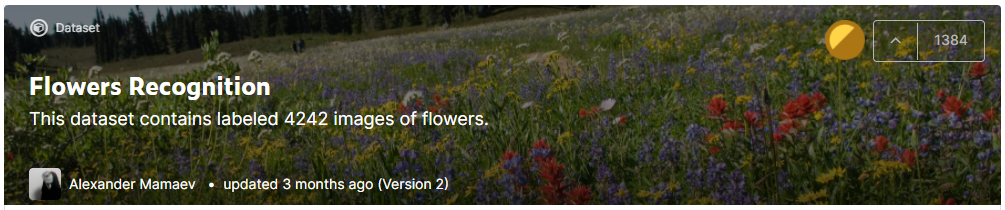

Informasi Dataset:

Jenis | Keterangan
--- | ---
Title | Flowers Recognition
Source | [Kaggle](https://www.kaggle.com/alxmamaev/flowers-recognition)
Owner | [Alexander Mamaev](https://www.kaggle.com/alxmamaev)
License | Unknown
Visibility | Public
Tags | image data, multiclass classification, plants
Usability | 6.3
Type | Image

In [4]:
# Download dataset
!kaggle datasets download -d alxmamaev/flowers-recognition

 96% 215M/225M [00:02<00:00, 141MB/s]
100% 225M/225M [00:02<00:00, 110MB/s]


In [5]:
# melakukan ekstraksi pada file zip
import zipfile
local_zip = 'flowers-recognition.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/content/flowers-recognition/')
zip_ref.close()

In [6]:
# Menghapus berkas zip yang sudah tidak diperlukan
!rm flowers-recognition.zip

## Data Understanding

Untuk memahami dataset berupa gambar, saya mendefinisikan terlebih dahulu direktori datasetnya ke dalam sebuah variabel. Selanjutnya tiap kelas atau label yang tersedia dapat diketahui dengan memanggil `os.listdir` 

In [7]:
# Mendefinisikan direktori utama dataset
base_dir = '/content/flowers-recognition/flowers'

In [8]:
print(os.listdir(base_dir))

['daisy', 'sunflower', 'dandelion', 'rose', 'tulip']


Untuk mengetahui jumlah file yang ada, dapat menggunakan fungsi `len()` pada tiap direktori label dan menjumlahkannya. Untuk memudahkan pembacaan data dapat juga divisualisasikan menggunakan bantuan library `matplotlib`.

In [9]:
# Menghitung jumlah gambar pada dataset
number_label = {}
total_files = 0
for i in os.listdir(base_dir):
    counting = len(os.listdir(os.path.join(base_dir, i)))
    number_label[i] = counting
    total_files += counting

print("Total Files : " + str(total_files))

Total Files : 4317


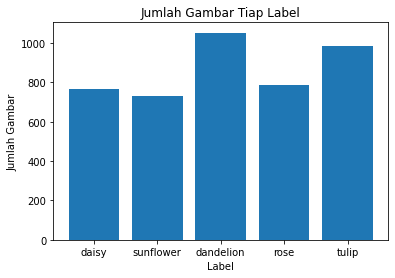

In [10]:
# Visualisasi jumlah gambar tiap kelas
import matplotlib.pyplot as plt

plt.bar(number_label.keys(), number_label.values());
plt.title("Jumlah Gambar Tiap Label");
plt.xlabel('Label');
plt.ylabel('Jumlah Gambar');

Dari diagram batang di atas dapat diketahui bahwa gambar yang ada pada setiap label memiliki jumlah yang berbeda-beda. Semua label memiliki jumlah lebih dari 700 gambar. Jumlah gambar paling banyak ada pada bunga Dandelion, sedangkan yang paling sedikit adalah bunga matahari (Sunflower). Namun perbedaan jumlah gambar tidak terlalu jauh dan tidak perlu diseimbangkan.

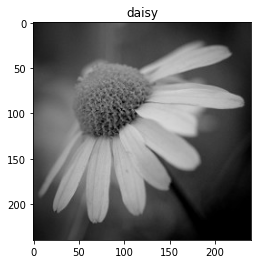

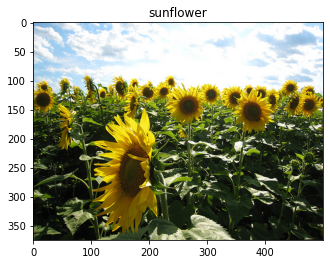

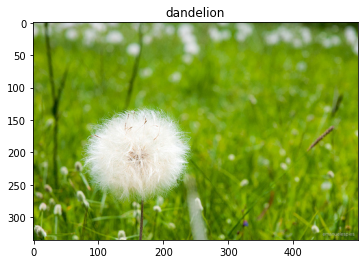

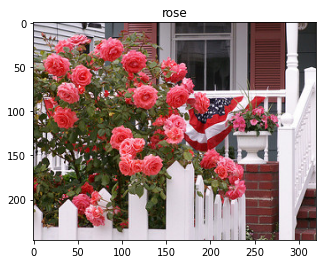

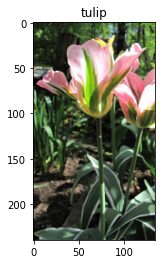

In [11]:
# Menampilkan sampel gambar tiap kelas
import matplotlib.image as mpimg

img_each_class = 1
img_samples = {}
classes = list(number_label.keys())


for c in classes:
    temp = os.listdir(os.path.join(base_dir, c))[:img_each_class]
    for item in temp:
        img_path = os.path.join(base_dir, c, item)
        img_samples[c] = img_path

for i in img_samples:
    fig = plt.gcf()
    img = mpimg.imread(img_samples[i])
    plt.title(i)
    plt.imshow(img)
    plt.show()

Dari beberapa gambar di atas dapat diketahui bahwa gambar yang tersedia pada dataset ini memiliki ukuran yang berbeda-beda.

## Data Preparation

Setelah memahami data, selanjutnya adalah mempersiapkan data sebelum nantinya masuk ke modelling. Penyiapan ini termasuk didalamnya adalah pembagian data _(split)_ menjadi data latih dan validasi. Pembagian data ini diperlukan sebelum nantinya digunakan untuk melatih model yang dibuat serta menghitung akurasi modelnya.

In [12]:
IMAGE_SIZE = (200,200)
BATCH_SIZE = 32
SEED = 999

In [13]:
# Menggunakan ImageDataGenerator untuk preprocessing
import tensorflow as tf

datagen = tf.keras.preprocessing.image.ImageDataGenerator(
    validation_split=0.2
)

In [15]:
# Menyiapkan data train dan data validation
train_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='training',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

valid_data = datagen.flow_from_directory(
    base_dir,
    class_mode='categorical',
    subset='validation',
    target_size=IMAGE_SIZE,
    batch_size=BATCH_SIZE,
    seed=SEED
)

Found 3457 images belonging to 5 classes.
Found 860 images belonging to 5 classes.


Selain membagi data, akan diterapkan juga image augmentation. Hal ini diterapkan berdasarkan data gambar yang telah ditampilkan sebelumnya. Image augmentation yang dilakukan
 di sini menggunakan layer RandomFlip, RandomRotation, RandomZoom serta Rescaling pada gambar.

In [17]:
# Image Augmentation
data_augmentation = tf.keras.Sequential(
  [
    tf.keras.layers.RandomFlip("horizontal",
                      input_shape=(IMAGE_SIZE[0],
                                  IMAGE_SIZE[1],
                                  3)),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.Rescaling(1./255)
  ]
)

## Modelling

### Membuat Arsitektur CNN

#### Penyusunan Layer

In [18]:
# Membuat arsitektur model CNN
cnn_model = tf.keras.models.Sequential([
  data_augmentation,
  tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
  tf.keras.layers.MaxPooling2D(),
  tf.keras.layers.Dropout(0.3),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

# Compiling model
cnn_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

#### Melatih Model CNN

In [19]:
# Training model CNN
cnn_hist = cnn_model.fit(
    train_data,
    epochs=20,
    validation_data = valid_data
)

Epoch 1/20
109/109 [==============================] - 48s 149ms/step - loss: 1.3233 - accuracy: 0.4235 - val_loss: 1.1374 - val_accuracy: 0.5163
Epoch 2/20
109/109 [==============================] - 16s 144ms/step - loss: 1.1199 - accuracy: 0.5398 - val_loss: 1.1551 - val_accuracy: 0.5465
Epoch 3/20
109/109 [==============================] - 16s 146ms/step - loss: 1.0265 - accuracy: 0.6014 - val_loss: 1.0996 - val_accuracy: 0.5709
Epoch 4/20
109/109 [==============================] - 16s 145ms/step - loss: 0.9456 - accuracy: 0.6213 - val_loss: 1.0709 - val_accuracy: 0.5965
Epoch 5/20
109/109 [==============================] - 16s 144ms/step - loss: 0.8884 - accuracy: 0.6561 - val_loss: 0.9500 - val_accuracy: 0.6058
Epoch 6/20
109/109 [==============================] - 16s 143ms/step - loss: 0.8633 - accuracy: 0.6618 - val_loss: 0.8687 - val_accuracy: 0.6674
Epoch 7/20
109/109 [==============================] - 15s 139ms/step - loss: 0.8262 - accuracy: 0.6775 - val_loss: 0.9284 - val_ac

#### Evaluasi Model CNN

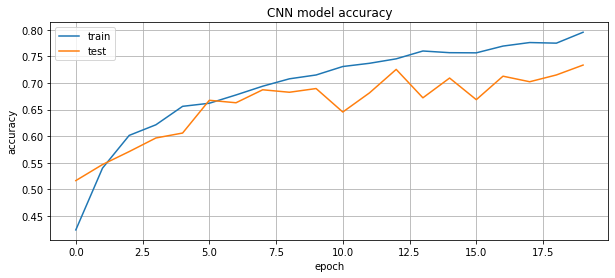

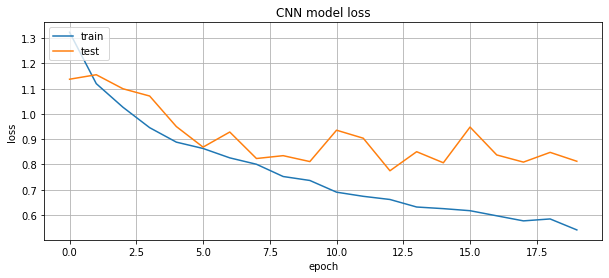

In [20]:
# Membuat plot akurasi model CNN
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['accuracy'])
plt.plot(cnn_hist.history['val_accuracy'])
plt.title('CNN model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model CNN
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['loss'])
plt.plot(cnn_hist.history['val_loss'])
plt.title('CNN model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

### Transfer Learning Menggunakan VGG16

#### Memuat Model VGG16

In [23]:
import tensorflow as tf
from tensorflow.keras.applications.vgg16 import VGG16

## Loading VGG16 model
base_vgg_model = VGG16(weights="imagenet", include_top=False, input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3))
base_vgg_model.trainable = False

# Preprocessing Input
vgg_preprocess = tf.keras.applications.vgg16.preprocess_input
train_data.preprocessing_function = vgg_preprocess

In [24]:
# Transfer learning dengan VGG16
vgg_model = tf.keras.models.Sequential([
  data_augmentation,
  base_vgg_model,
  tf.keras.layers.Dropout(0.7),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

# Compiling model
vgg_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

#### Melatih Model

In [25]:
# Melatih model VGG16
vgg_hist = vgg_model.fit(
    train_data,
    epochs=20,
    validation_data = valid_data
)

Epoch 1/20
109/109 [==============================] - 48s 349ms/step - loss: 1.0957 - accuracy: 0.5806 - val_loss: 0.7420 - val_accuracy: 0.7209
Epoch 2/20
109/109 [==============================] - 30s 272ms/step - loss: 0.7863 - accuracy: 0.7128 - val_loss: 0.6353 - val_accuracy: 0.7721
Epoch 3/20
109/109 [==============================] - 30s 273ms/step - loss: 0.7150 - accuracy: 0.7330 - val_loss: 0.5945 - val_accuracy: 0.7802
Epoch 4/20
109/109 [==============================] - 30s 273ms/step - loss: 0.6732 - accuracy: 0.7501 - val_loss: 0.6024 - val_accuracy: 0.7884
Epoch 5/20
109/109 [==============================] - 30s 272ms/step - loss: 0.6826 - accuracy: 0.7472 - val_loss: 0.5597 - val_accuracy: 0.8023
Epoch 6/20
109/109 [==============================] - 30s 273ms/step - loss: 0.6367 - accuracy: 0.7677 - val_loss: 0.5582 - val_accuracy: 0.7849
Epoch 7/20
109/109 [==============================] - 30s 273ms/step - loss: 0.5901 - accuracy: 0.7755 - val_loss: 0.5968 - val_ac

#### Evaluasi Model

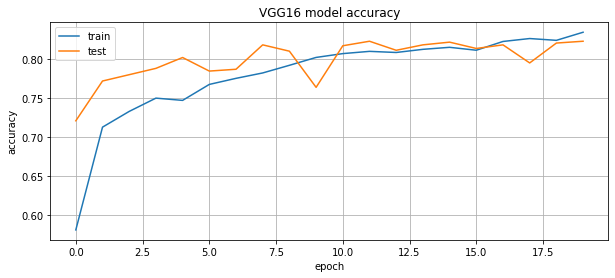

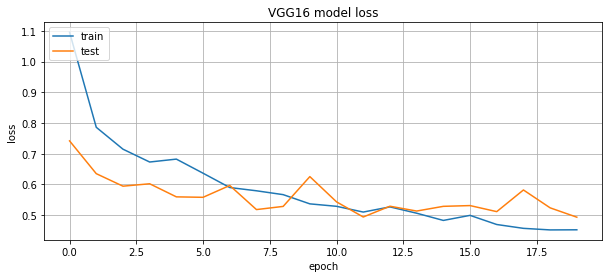

In [26]:
# Membuat plot akurasi model VGG16
plt.figure(figsize=(10,4))
plt.plot(vgg_hist.history['accuracy'])
plt.plot(vgg_hist.history['val_accuracy'])
plt.title('VGG16 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model VGG16
plt.figure(figsize=(10,4))
plt.plot(vgg_hist.history['loss'])
plt.plot(vgg_hist.history['val_loss'])
plt.title('VGG16 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

### Transfer Learning Menggunakan ResNet50

#### Memuat Model ResNet50

In [40]:
from tensorflow.keras.applications import ResNet50

# Loading ResNet50 model
base_resnet_model = ResNet50(include_top=False,
                   input_shape=(IMAGE_SIZE[0],IMAGE_SIZE[1],3),
                   pooling='max',classes=5,
                   weights='imagenet')

base_resnet_model.trainable = False

train_data.preprocessing_function = tf.keras.applications.resnet50.preprocess_input


# Transfer learning ResNet50
resnet_model = tf.keras.models.Sequential([
    data_augmentation,
    base_resnet_model,
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(5, activation="softmax")
])


In [41]:
# Compiling model
resnet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

#### Melatih Model

In [42]:
# Melatih model ResNet50
resnet_hist = resnet_model.fit(
    train_data,
    epochs=20,
    validation_data = valid_data
)

Epoch 1/20
109/109 [==============================] - 34s 268ms/step - loss: 1.6711 - accuracy: 0.2520 - val_loss: 1.7887 - val_accuracy: 0.1744
Epoch 2/20
109/109 [==============================] - 28s 257ms/step - loss: 1.5959 - accuracy: 0.2870 - val_loss: 1.5167 - val_accuracy: 0.3628
Epoch 3/20
109/109 [==============================] - 28s 257ms/step - loss: 1.5533 - accuracy: 0.3124 - val_loss: 1.4939 - val_accuracy: 0.3140
Epoch 4/20
109/109 [==============================] - 28s 257ms/step - loss: 1.5243 - accuracy: 0.3217 - val_loss: 1.5017 - val_accuracy: 0.3547
Epoch 5/20
109/109 [==============================] - 28s 258ms/step - loss: 1.5111 - accuracy: 0.3251 - val_loss: 1.4774 - val_accuracy: 0.3651
Epoch 6/20
109/109 [==============================] - 28s 258ms/step - loss: 1.4908 - accuracy: 0.3419 - val_loss: 1.4303 - val_accuracy: 0.4070
Epoch 7/20
109/109 [==============================] - 28s 258ms/step - loss: 1.4630 - accuracy: 0.3723 - val_loss: 1.4275 - val_ac

#### Evaluasi Model

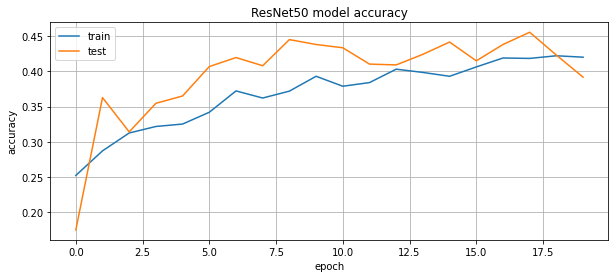

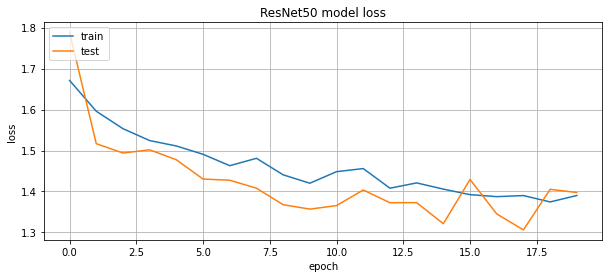

In [43]:
# Membuat plot akurasi model ResNet50
plt.figure(figsize=(10,4))
plt.plot(resnet_hist.history['accuracy'])
plt.plot(resnet_hist.history['val_accuracy'])
plt.title('ResNet50 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model ResNet50
plt.figure(figsize=(10,4))
plt.plot(resnet_hist.history['loss'])
plt.plot(resnet_hist.history['val_loss'])
plt.title('ResNet50 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

### Transfer Learning Menggunakan DenseNet201

#### Memuat Model DenseNet201

In [34]:
# Loading DenseNet201 model
base_densenet_model = tf.keras.applications.DenseNet201(include_top=False,
                                                        weights='imagenet',
                                                        input_shape=(IMAGE_SIZE[0], IMAGE_SIZE[1], 3),
                                                        pooling='max')
base_densenet_model.trainable=False
train_data.preprocessing_function = tf.keras.applications.densenet.preprocess_input

In [35]:
# Transfer learning DenseNet201
densenet_model = tf.keras.models.Sequential([
  data_augmentation,
  base_densenet_model,
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Flatten(),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(64, activation='relu'),
  tf.keras.layers.Dense(5, activation='softmax')
])

# Compiling model
densenet_model.compile(
    loss='categorical_crossentropy',
    optimizer=tf.keras.optimizers.Adam(),
    metrics=['accuracy']
  )

#### Melatih Model

In [36]:
# Melatih model DenseNet201
densenet_hist = densenet_model.fit(
    train_data,
    epochs=20,
    validation_data = valid_data
)

Epoch 1/20
109/109 [==============================] - 59s 407ms/step - loss: 0.8999 - accuracy: 0.6535 - val_loss: 0.4341 - val_accuracy: 0.8453
Epoch 2/20
109/109 [==============================] - 37s 336ms/step - loss: 0.5084 - accuracy: 0.8114 - val_loss: 0.3802 - val_accuracy: 0.8686
Epoch 3/20
109/109 [==============================] - 37s 337ms/step - loss: 0.4422 - accuracy: 0.8473 - val_loss: 0.4108 - val_accuracy: 0.8593
Epoch 4/20
109/109 [==============================] - 37s 336ms/step - loss: 0.4136 - accuracy: 0.8426 - val_loss: 0.3894 - val_accuracy: 0.8605
Epoch 5/20
109/109 [==============================] - 37s 337ms/step - loss: 0.4071 - accuracy: 0.8499 - val_loss: 0.4483 - val_accuracy: 0.8616
Epoch 6/20
109/109 [==============================] - 37s 337ms/step - loss: 0.3583 - accuracy: 0.8649 - val_loss: 0.3835 - val_accuracy: 0.8744
Epoch 7/20
109/109 [==============================] - 37s 339ms/step - loss: 0.3307 - accuracy: 0.8756 - val_loss: 0.3840 - val_ac

#### Evaluasi Model

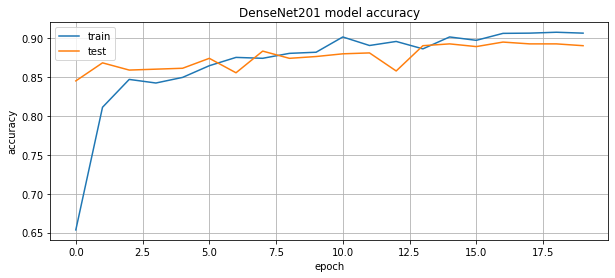

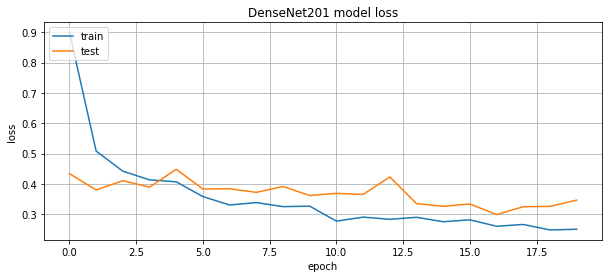

In [37]:
# Membuat plot akurasi model DenseNet201
plt.figure(figsize=(10,4))
plt.plot(densenet_hist.history['accuracy'])
plt.plot(densenet_hist.history['val_accuracy'])
plt.title('DenseNet201 model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

print()

# Membuat plot loss model DenseNet201
plt.figure(figsize=(10,4))
plt.plot(densenet_hist.history['loss'])
plt.plot(densenet_hist.history['val_loss'])
plt.title('DenseNet201 model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.grid(True)
plt.show()

## Evaluation
Setelah membuat beberapa model, maka dapat kita bandingkan akurasi dari model-model tersebut dengan visualisasi berikut ini.


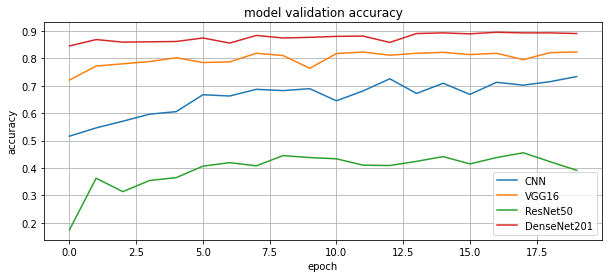

In [44]:
# Membuat plot akurasi empat model sebelumnya untuk dibandingkan
plt.figure(figsize=(10,4))
plt.plot(cnn_hist.history['val_accuracy'])
plt.plot(vgg_hist.history['val_accuracy'])
plt.plot(resnet_hist.history['val_accuracy'])
plt.plot(densenet_hist.history['val_accuracy'])
plt.title('model validation accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['CNN', 'VGG16', 'ResNet50', 'DenseNet201'], loc='lower right')
plt.grid(True)
plt.show()

Dari hasil tersebut dapat diketahui bahwa model dengan DenseNet201 memiliki kinerja yang lebih baik. Untuk itu model tersebut yang akan dipilih untuk digunakan.

## Uji Coba Model

Setelah mendapatkan model dengan kinerja yang baik, maka dapat diujicobakan untuk mengenali gambar bunga.

In [45]:
# Menampilkan daftar kelas atau label gambar
train_data.class_indices

{'daisy': 0, 'dandelion': 1, 'rose': 2, 'sunflower': 3, 'tulip': 4}

Saving FL3230_Sunflower_Zebulon_11_1024x1024.jpg to FL3230_Sunflower_Zebulon_11_1024x1024.jpg
FL3230_Sunflower_Zebulon_11_1024x1024.jpg
sunflower


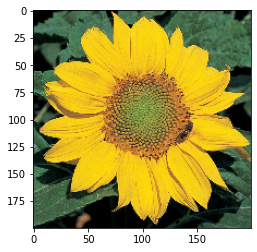

In [46]:
# Menguji coba model
import numpy as np
from keras.preprocessing import image
%matplotlib inline
 
uploaded = files.upload()
 
for fn in uploaded.keys():
 
  # predicting images
  path = fn
  img = image.load_img(path, target_size=IMAGE_SIZE)
  imgplot = plt.imshow(img)
  x = image.img_to_array(img)
  x = np.expand_dims(x, axis=0)
 
  images = np.vstack([x])
  classes = densenet_model.predict(images, batch_size=BATCH_SIZE)
  classes = np.argmax(classes)
  
  print(fn)
  if classes==0:
    print('daisy')
  elif classes==1:
    print('dandelion')
  elif classes==2:
    print('rose')
  elif classes==3:
    print('sunflower')
  else:
    print('tulip')

## Deployment
Agar nantinya dapat diimplementasikan atau dikembangkan lebih lanjut, model perlu di-deploy terlebih dahulu dalam format HDF5, TFLite (Mobile) atau TensorflowJS (Web)

### HDF5

In [50]:
densenet_model.save('model-flowers-recognition.h5')

### TFLite

In [51]:
converter = tf.lite.TFLiteConverter.from_keras_model(densenet_model)
tflite_model = converter.convert()
with tf.io.gfile.GFile('model-flowers-recognition.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: /tmp/tmpato93_i0/assets


INFO:tensorflow:Assets written to: /tmp/tmpato93_i0/assets


### TensorflowJS

In [53]:
# Instal TensorflowJS
!pip install tensorflowjs

In [55]:
!tensorflowjs_converter \
    --input_format=keras \
    /content/model-flowers-recognition.h5 /content/modeltfjs

## Penutup
Saat ini model machine learning untuk mengenali gambar bunga telah didapatkan. Dengan model ini dapat diimplementasikan lebih lanjut menjadi aplikasi web atau mobile untuk mengenali jenis bunga. Namun tentu saja model ini juga masih dapat disempurnakan dengan mencoba pretrained model yang lain, melakukan fine-tuning, atau dengan mengubah dataset yang lebih beragam dan berkualitas.